In [1]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from tqdm import tqdm_notebook
%matplotlib inline

MAX_ITERATION = 10000

In [2]:
def data_generator(inland):
    if inland == False:
        X1 = np.array([[119.28, 26.08],    # 福州
                       [121.31, 25.03],    # 台北
                       [121.47, 31.23],    # 上海
                       [118.06, 24.27],    # 厦门
                       [121.46, 39.04],    # 大连
                       [122.10, 37.50],    # 威海
                       [124.23, 40.07]])   # 丹东

        X2 = np.array([[129.87, 32.75],    # 长崎
                       [130.33, 31.36],    # 鹿儿岛
                       [131.42, 31.91],    # 宫崎
                       [130.24, 33.35],    # 福冈
                       [133.33, 15.43],    # 鸟取
                       [138.38, 34.98],    # 静冈
                       [140.47, 36.37]])   # 水户
        y1 = np.full(X1.shape[0], -1)
        y2 = np.ones(X2.shape[0])

        X_train = np.concatenate((X1, X2), axis=0)
        y_train = np.concatenate((y1, y2))
        X_train, y_train = shuffle(X_train, y_train)
        X_test = np.array([[123.28, 25.45]])
        y_test = np.array([-1])

        return X_train, y_train, X_test, y_test

    else:
        X1 = np.array([[119.28, 26.08],    # 福州
                       [121.31, 25.03],    # 台北
                       [121.47, 31.23],    # 上海
                       [118.06, 24.27],    # 厦门
                       [113.53, 29.58],    # 武汉
                       [104.06, 30.67],    # 成都
                       [116.25, 39.54],    # 北京
                       [121.46, 39.04],    # 大连
                       [122.10, 37.50],    # 威海
                       [124.23, 40.07]])   # 丹东

        X2 = np.array([[129.87, 32.75],    # 长崎
                       [130.33, 31.36],    # 鹿儿岛
                       [131.42, 31.91],    # 宫崎
                       [130.24, 33.35],    # 福冈
                       [136.54, 35.10],    # 名古屋
                       [132.27, 34.24],    # 广岛
                       [139.46, 35.42],    # 东京
                       [133.33, 15.43],    # 鸟取
                       [138.38, 34.98],    # 静冈
                       [140.47, 36.37]])   # 水户
        y1 = np.full(X1.shape[0], -1)
        y2 = np.ones(X2.shape[0])

        X_train = np.concatenate((X1, X2), axis=0)
        y_train = np.concatenate((y1, y2))
        X_train, y_train = shuffle(X_train, y_train)
        X_test = np.array([[123.28, 25.45]])
        y_test = np.array([-1])

        return X_train, y_train, X_test, y_test


def primal_SVM(X, y):
    X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
    N, d = X.shape
    temp = np.eye(d)
    temp[0, 0] = 0.0
    Q = matrix(temp)
    p = matrix(-np.zeros(d))
    G = matrix(-y.reshape(-1, 1) * X)
    h = matrix(-np.ones(N))

    sol = solvers.qp(Q, p, G, h)
    w = np.array(sol['x']).reshape(-1)
    print('Final weight vector is:', w)

    return w


def dual_SVM(X, y):
    N = X.shape[0]
    temp = y.reshape(-1, 1) * X
    Q = matrix(np.dot(temp, temp.T).astype(np.double))
    p = matrix(-np.ones(N))
    G = matrix(-np.eye(N)[range(0, N)])
    h = matrix(np.zeros(N))
    A = matrix(y.astype(np.double), (1, N))
    b = matrix(0.0)

    sol = solvers.qp(Q, p, G, h, A, b)
    alpha = np.array(sol['x']).reshape(-1)
    w = np.dot(alpha * y, X)
    non_zero_index = np.where(np.abs(alpha) > 1e-6)[0][0]
    b = y[non_zero_index] - np.dot(w, X[non_zero_index])
    w = np.append(b, w)
    print('Final weight vector is:', w)
    
    return w


def SVM_pegasos(X, y, w_init, max_iter, weight_decay, lr, eps=1e-6):
    w = w_init
    X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
    diff = np.zeros(3)

    for t in tqdm_notebook(range(max_iter)):
        diff = weight_decay * w
        for n in range(len(X)):
            if y[n]*np.dot(w, X[n]) < 1:
                diff += -y[n]*X[n]
        w_ = w - lr/(t+1) * diff
        delta = np.linalg.norm(w - w_)
        if delta < eps:
            break
        else:
            w = w_
    print('Final weight vector is:', w)
    
    return w


def SVM_drawer(X_train, y_train, X_test, y_test, w):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    for i in range(len(y_train)):
        if y_train[i] == 1:
            ax.scatter(X_train[i, 0], X_train[i, 1], c='r', marker='o')
        else:
            ax.scatter(X_train[i, 0], X_train[i, 1], c='b', marker='x')

    for i in range(len(y_test)):
        if y_test[i] == 1:
            ax.scatter(X_test[i, 0], X_test[i, 1], c='r', s=200, marker='*')
        else:
            ax.scatter(X_test[i, 0], X_test[i, 1], c='b', s=200, marker='*')

    l_x = np.linspace(100, 150, X_train.shape[0])
#     l_x = np.linspace(np.min(X_train)-0.5, np.max(X_train)+0.5, X_train.shape[0])
    l_y = -(w[0]/w[2]+w[1]/w[2]*l_x)
    ax.plot(l_x, l_y)
    xy_max = np.max(X_train, axis=0)
    xy_min = np.min(X_train, axis=0)
    ax.set(xlim=(100, 150), ylim=(15, 45),
           xlabel="x",
           ylabel="y",
           title="SVM")
#     ax.set(xlim=(xy_min[0]-0.5, xy_max[0]+0.5), ylim=(xy_min[1]-0.5, xy_max[1]+0.5),
#            xlabel="x",
#            ylabel="y",
#            title="Dual SVM")

# Primal SVM

     pcost       dcost       gap    pres   dres
 0:  9.0724e-03  6.3515e+00  4e+01  2e+00  1e+02
 1:  8.1712e-02 -7.4726e+00  1e+01  4e-01  3e+01
 2:  1.1719e-01 -1.2084e-01  2e-01  4e-03  4e-01
 3:  5.4376e-02  2.4933e-02  3e-02  6e-15  2e-14
 4:  4.2043e-02  3.8454e-02  4e-03  4e-15  4e-14
 5:  4.1638e-02  4.1578e-02  6e-05  4e-15  7e-14
 6:  4.1624e-02  4.1624e-02  6e-07  3e-15  3e-14
 7:  4.1624e-02  4.1624e-02  6e-09  4e-15  4e-14
Optimal solution found.
Final weight vector is: [-33.98333018   0.28323918  -0.05499058]


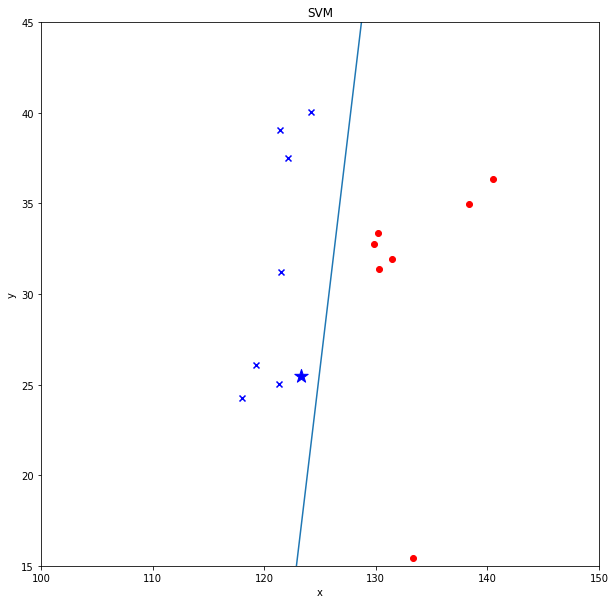

In [17]:
X_train, y_train, X_test, y_test = data_generator(inland=False)
w = primal_SVM(X_train, y_train)
SVM_drawer(X_train, y_train, X_test, y_test, w)

     pcost       dcost       gap    pres   dres
 0:  4.5703e-03  1.5099e+01  6e+01  2e+00  3e+02
 1:  4.6198e-02 -1.1101e+01  2e+01  5e-01  9e+01
 2:  8.0671e-02 -1.1034e+00  1e+00  2e-02  5e+00
 3:  7.1962e-02  1.2370e-02  6e-02  7e-15  2e-13
 4:  4.2696e-02  3.4933e-02  8e-03  4e-15  7e-14
 5:  4.1747e-02  4.1277e-02  5e-04  5e-15  4e-14
 6:  4.1625e-02  4.1621e-02  5e-06  3e-15  8e-14
 7:  4.1624e-02  4.1624e-02  5e-08  3e-15  3e-14
Optimal solution found.
Final weight vector is: [-33.98333476   0.28323921  -0.05499059]


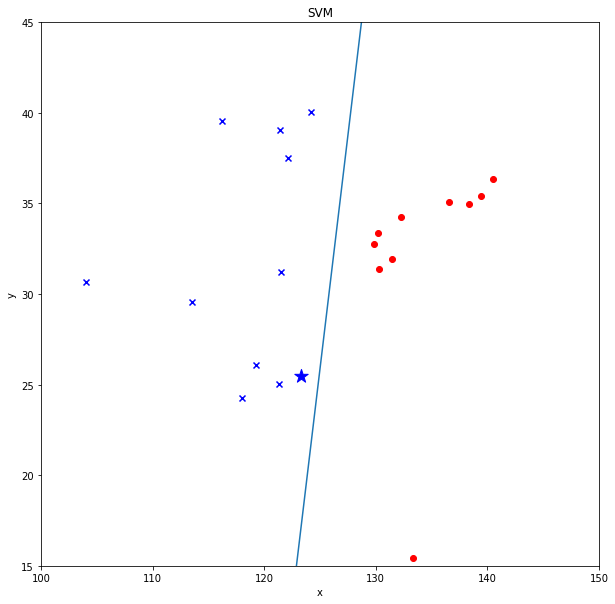

In [18]:
X_train, y_train, X_test, y_test = data_generator(inland=True)
w = primal_SVM(X_train, y_train)
SVM_drawer(X_train, y_train, X_test, y_test, w)

# Dual SVM

     pcost       dcost       gap    pres   dres
 0: -2.4282e+00 -4.1387e+00  4e+01  6e+00  2e+00
 1: -7.8678e-01 -4.4407e-01  1e+01  1e+00  4e-01
 2:  4.9327e-03 -1.1769e-01  2e-01  2e-02  4e-03
 3: -2.4933e-02 -5.4376e-02  3e-02  8e-18  7e-14
 4: -3.8454e-02 -4.2043e-02  4e-03  4e-18  6e-14
 5: -4.1578e-02 -4.1638e-02  6e-05  5e-18  9e-14
 6: -4.1624e-02 -4.1624e-02  6e-07  1e-17  9e-14
 7: -4.1624e-02 -4.1624e-02  6e-09  5e-18  5e-14
Optimal solution found.
Final weight vector is: [-33.98333015   0.28323918  -0.05499058]


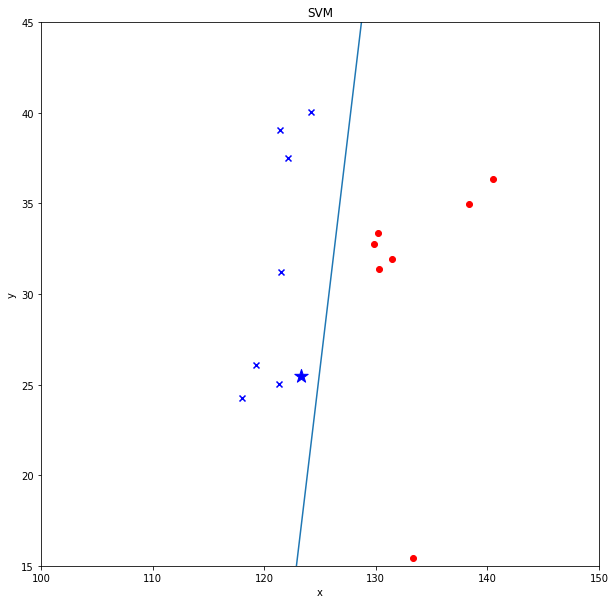

In [19]:
X_train, y_train, X_test, y_test = data_generator(inland=False)
w = dual_SVM(X_train, y_train)
SVM_drawer(X_train, y_train, X_test, y_test, w)

     pcost       dcost       gap    pres   dres
 0: -4.9743e+00 -8.4377e+00  6e+01  9e+00  2e+00
 1: -4.8968e+00 -2.3887e+00  2e+01  3e+00  5e-01
 2: -1.8059e-01 -8.7088e-02  1e+00  1e-01  2e-02
 3: -1.2370e-02 -7.1962e-02  6e-02  5e-17  7e-13
 4: -3.4933e-02 -4.2696e-02  8e-03  1e-17  1e-13
 5: -4.1277e-02 -4.1747e-02  5e-04  8e-18  6e-14
 6: -4.1621e-02 -4.1625e-02  5e-06  5e-18  1e-13
 7: -4.1624e-02 -4.1624e-02  5e-08  2e-17  1e-13
Optimal solution found.
Final weight vector is: [-33.98333462   0.28323921  -0.05499059]


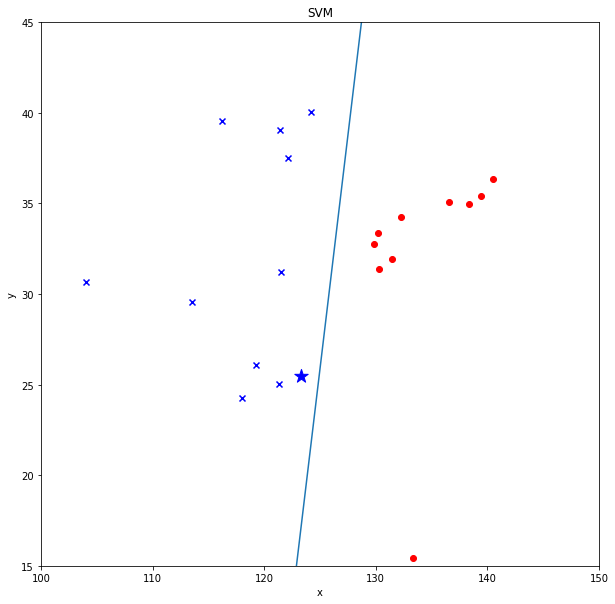

In [20]:
X_train, y_train, X_test, y_test = data_generator(inland=True)
w = dual_SVM(X_train, y_train)
SVM_drawer(X_train, y_train, X_test, y_test, w)

# SVM Pegasos


Final weight vector is: [-34.12389726   0.28777998  -0.0636623 ]


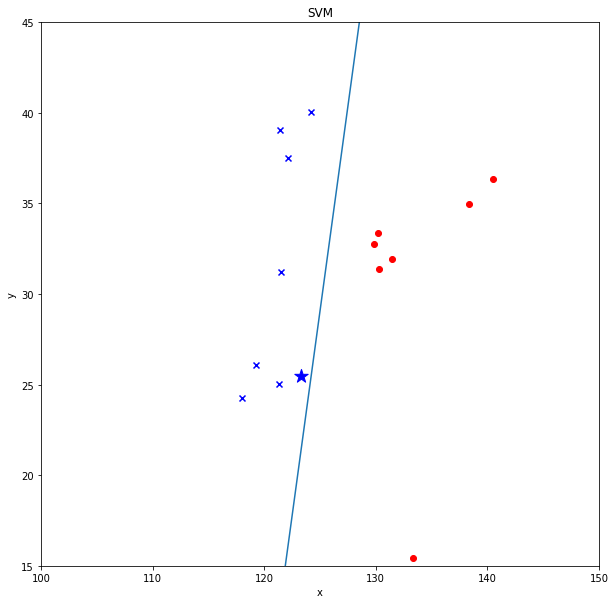

In [21]:
X_train, y_train, X_test, y_test = data_generator(inland=False)
np.random.seed()
w_init = np.random.randn(3)
w = SVM_pegasos(X_train, y_train, w_init, 1000000, weight_decay=0.001, lr=8)
SVM_drawer(X_train, y_train, X_test, y_test, w)


Final weight vector is: [-32.75762887   0.27500985  -0.0642037 ]


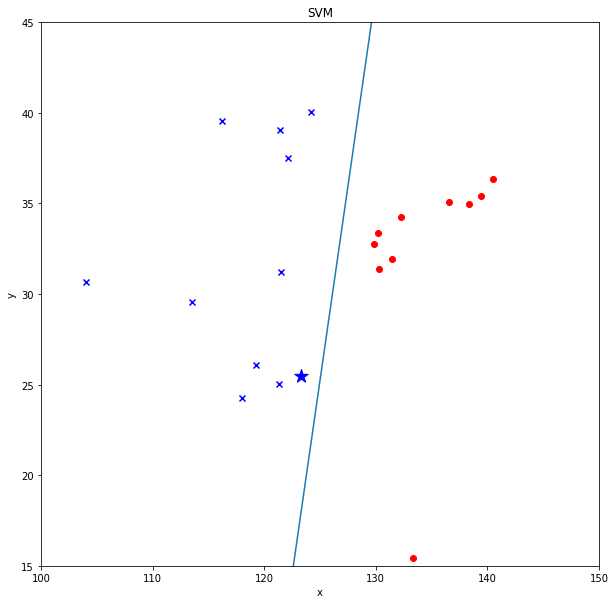

In [22]:
X_train, y_train, X_test, y_test = data_generator(inland=True)
np.random.seed()
w_init = np.random.randn(3)
w = SVM_pegasos(X_train, y_train, w_init, 1000000, weight_decay=0.01, lr=8)
SVM_drawer(X_train, y_train, X_test, y_test, w)